<a ><font size="4"><b> Setup and load dependencies</b></font></a>


In [2]:
cd /mnt/d/AI/Algerian Forest Fire Prediction

/mnt/d/AI/Algerian Forest Fire Prediction


In [3]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from IPython.core.interactiveshell import InteractiveShell

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# sns.set_context('talk')
# InteractiveShell.ast_node_interactivity = "all"

palette_color  = sns.color_palette("RdBu",5)
sns.set_theme(style="whitegrid", palette=palette_color)

palette_color

[(0.7893886966551327, 0.2768166089965398, 0.2549019607843137),
 (0.9686274509803922, 0.7176470588235293, 0.5999999999999999),
 (0.9657054978854287, 0.9672433679354094, 0.9680891964628989),
 (0.654901960784314, 0.8143790849673205, 0.8941176470588236),
 (0.21568627450980393, 0.5141868512110727, 0.7328719723183391)]

<h1 ><font ><b>Helper Functions</b></font></h1>


In [6]:
def CheckMissing(df):
    missing = df.isna().sum().sort_values(ascending = False)
    missing = missing[missing > 0]
    if missing.sum()!=0: 
        missing_percent = missing / len(df) * 100

        missing_info = pd.DataFrame({
            'Feature': missing.index,
            'NumMissing': missing.values,
            'PercentMissing':missing_percent.values,
            'NumUnique': df[missing.index].nunique().values,
            'MostCommon': df[missing.index].mode().iloc[0].values
        })

        return missing_info
    else: 
        print("Dataset has No Nulls")
        return 0

<a ><font size="3"><b>Descriptive statistics</b></font></a>

Here are some common descriptive statistics measures:

- Measures of central tendency: Mean, Median, and Mode.
- Measures of variability: Variance, Standard deviation, and Range.
- Measures of shape:
    - Skewness: the degree of asymmetry of the data.
    - Kurtosis: the degree of peakedness or flatness of the data.

In [7]:
def DescriptiveStats(df):
    stats_df = df.describe(include = 'all').transpose()
    stats_df['skewness'] = np.nan
    stats_df['kurtosis'] = np.nan
    for col in df.select_dtypes([np.number]).columns.to_list():

        stats_df.loc[col,'unique'] = df[col].nunique()
        stats_df.loc[col,'top'] = df[col].mode()[0]
        stats_df.loc[col,'freq'] = df[col].value_counts().values[0]
        stats_df.loc[col,'skewness'] = df[col].skew()
        stats_df.loc[col,'kurtosis'] = df[col].kurtosis()
   
    return stats_df

In [8]:
def n_cat_samples(df,cat_cols,target_col, num_bins=20, figsize=(7, 5), pie=True):
    
    InteractiveShell.ast_node_interactivity = 'last_expr'
    
    fig, axs = plt.subplots(nrows=len(cat_cols)+1, ncols=2, figsize=figsize)
    # Create a pie plot for each categorical column
    for i, feature in enumerate(cat_cols):

        value_counts = df[feature].value_counts().sort_values()

        if pie:
        
            axs[i, 0].pie(value_counts, labels=value_counts.index, 
                            colors=palette_color, autopct='%1.1f%%', pctdistance=1.2, 
                            labeldistance=1.5, textprops={'fontsize': 10})

        sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)

        axs[i, 0].set_title(feature, loc='left',fontsize=12, pad = 30)
        axs[i, 1].set_xlabel('', fontsize=10, rotation= 60)
        axs[i, 1].set_ylabel('', fontsize=10)
    
    axs[-1,0].remove()
    axs[-1,1].remove()
    
    plt.tight_layout(h_pad =0.5, pad=0.5)
    plt.legend(loc='best')
    plt.show()

### Dataset overview

In [9]:
df = pd.read_csv('data/raw/Algerian_forest_fires_dataset.csv')

In [10]:
InteractiveShell.ast_node_interactivity = 'all'
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          246 non-null    object
 1   month        245 non-null    object
 2   year         245 non-null    object
 3   Temperature  245 non-null    object
 4    RH          245 non-null    object
 5    Ws          245 non-null    object
 6   Rain         245 non-null    object
 7   FFMC         245 non-null    object
 8   DMC          245 non-null    object
 9   DC           245 non-null    object
 10  ISI          245 non-null    object
 11  BUI          245 non-null    object
 12  FWI          245 non-null    object
 13  Classes      244 non-null    object
dtypes: object(14)
memory usage: 27.1+ KB


In [11]:
DescriptiveStats(df)

,count,unique,top,freq,skewness,kurtosis
day,246,33,1,8,NaN,NaN
month,245,5,7,62,NaN,NaN
year,245,2,2012,244,NaN,NaN
Temperature,245,20,35,29,NaN,NaN
RH,245,63,55,10,NaN,NaN
Ws,245,19,14,43,NaN,NaN
Rain,245,40,0,133,NaN,NaN
FFMC,245,174,88.9,8,NaN,NaN
DMC,245,167,7.9,5,NaN,NaN
DC,245,199,8,5,NaN,NaN


### Handle missing values

In [12]:
CheckMissing(df)

,Feature,NumMissing,PercentMissing,NumUnique,MostCommon
0,Classes,3,1.215,9,fire
1,month,2,0.810,5,7
2,RH,2,0.810,63,55
3,Temperature,2,0.810,20,35
4,Ws,2,0.810,19,14
5,year,2,0.810,2,2012
6,DC,2,0.810,199,8
7,Rain,2,0.810,40,0
8,DMC,2,0.810,167,7.9
9,FFMC,2,0.810,174,88.9


In [13]:
df[df.isna().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,14,7,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


* **Row 168:** The `Classes` value is corrected to `'fire'` but its value written in the FWI column.

In [14]:
df.iloc[168,-2]=np.NaN
df.iloc[168,-1]='fire'

In [15]:
df[df.isna().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,14,7,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,NaN,fire


> As describe in the dataset , all rows from 0 to 122 (inclusive) were assigned to the "Bejaia region" and all rows from 124 onwards were assigned to "Sidi-Bel Abbes".

In [16]:
df['Region'] = np.NaN
df.loc[:122, "Region"]='Bejaia region'
df.loc[125:, "Region"]='Sidi-Bel Abbes'

/tmp/ipykernel_1698/1028272941.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bejaia region' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:122, "Region"]='Bejaia region'


In [17]:
df = df.dropna()

In [18]:
CheckMissing(df)

Dataset has No Nulls


0

### Handle Column Types

In [19]:
df.columns
df.columns = df.columns.str.strip()
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [20]:

df = df.astype({
    'Classes': 'category',
    'Region': 'category',
    'month': 'int',
    'RH': 'int',
    'Temperature': 'int',
    'Ws': 'int',
    'year': 'int',
    'DC': 'float',
    'Rain': 'float',
    'DMC': 'float',
    'FFMC': 'float',
    'BUI': 'float',
    'ISI': 'float',
    'FWI': 'float',
    'day': 'int'
})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 0 to 246
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   day          243 non-null    int64   
 1   month        243 non-null    int64   
 2   year         243 non-null    int64   
 3   Temperature  243 non-null    int64   
 4   RH           243 non-null    int64   
 5   Ws           243 non-null    int64   
 6   Rain         243 non-null    float64 
 7   FFMC         243 non-null    float64 
 8   DMC          243 non-null    float64 
 9   DC           243 non-null    float64 
 10  ISI          243 non-null    float64 
 11  BUI          243 non-null    float64 
 12  FWI          243 non-null    float64 
 13  Classes      243 non-null    category
 14  Region       243 non-null    category
dtypes: category(2), float64(7), int64(6)
memory usage: 27.5 KB
None


In [21]:
DescriptiveStats(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,skewness,kurtosis
day,243.000,31,1,8,15.761,8.843,1.000,8.000,16.000,23.000,31.000,0.000,-1.206
month,243.000,4,8,62,7.502,1.115,6.000,7.000,8.000,8.000,9.000,-0.005,-1.350
year,243.000,1,2012,243,2012.000,0.000,2012.000,2012.000,2012.000,2012.000,2012.000,0.000,0.000
Temperature,243.000,19,35,29,32.152,3.628,22.000,30.000,32.000,35.000,42.000,-0.191,-0.141
RH,243.000,62,55,10,62.041,14.828,21.000,52.500,63.000,73.500,90.000,-0.243,-0.509
Ws,243.000,18,14,43,15.494,2.811,6.000,14.000,15.000,17.000,29.000,0.556,2.622
Rain,243.000,39,0.000,133,0.763,2.003,0.000,0.000,0.000,0.500,16.800,4.569,25.823
FFMC,243.000,173,88.900,7,77.842,14.350,28.600,71.850,83.300,88.300,96.000,-1.320,1.040
DMC,243.000,165,7.900,5,14.681,12.393,0.700,5.800,11.300,20.800,65.900,1.523,2.463
DC,243.000,197,8.000,5,49.431,47.666,6.900,12.350,33.100,69.100,220.400,1.473,1.596


---
<h1 style="text-align:center;"><font color = "#2471A3">Data Exploration</font></h1>

---

This exploration aims to understand the relationships between fire risk factors (features) and the occurrence of forest fires ('Classes'). We'll employ visualization and hypothesis testing to gain insights.

#### **Data Visualization**

* **Target Distribution:**
    * Bar chart or pie chart showing the distribution of fire classes.
* **Feature Distributions:**
    * Histograms for numerical features.
    * Bar charts or pie charts for categorical features.
* **Heatmaps:**
    * Visual representation of the correlation matrix for nummerical features.
* **Pairplot:** 
    * Visualize the relationship between all pairs of nummerical features.
    * Visualize the relationship between nummerical features and target variable.    
<!-- * **Boxplots:**
    * Compare the distribution of numerical features across different fire classes. -->

#### **Hypothesis Testing:**

* **T-Tests:**  
Use t-tests to compare the means of numerical features between different fire classes.
* **Chi-Square Test:**
    * Test for association between categorical features.
    * Test for association between categorical features and target variable.  

#### **Additional Exploration**

* **VIF:**
    * Assess the variance inflation factor to detect multicollinearity issues.
* **Mutual Information:**
    * Measure the dependency between categorical features and target variable.
* **Feature Importance:** 
    * Use machine learning models to determine feature importance.

<!-- **Feature Engineering**

* **Feature Derivation:**
    * Create new features based on existing variables (e.g., interaction terms, ratios).
* **Feature Selection:**
    * Identify the most important features using techniques like Random Forest feature importance. -->


In [22]:
categorical_features = ['Region', 'year', 'month', 'day']
numerical_features = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']

### 1. Explore Categorical Features

#### Distribution of targe variable 
Check the frequency of each fire class. This provides an initial understanding of the class imbalance.


In [23]:
df.Classes.value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

In [24]:
df.Classes = df.Classes.str.strip()
print("\nFire vs. No Fire Counts:")
df.Classes.value_counts(normalize=True)


Fire vs. No Fire Counts:


Classes
fire       0.564
not fire   0.436
Name: proportion, dtype: float64

#### Distribution of categorical features

* **Bar Chart:** shows the percentage distribution of each category across the target variable.
* **Pie Chart:** shows the frequency of each category on the x-axis. 

/tmp/ipykernel_1698/1103479964.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)
/tmp/ipykernel_1698/1103479964.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)
/tmp/ipykernel_1698/1103479964.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)
/tmp/ipykernel_1698/1103479964.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)


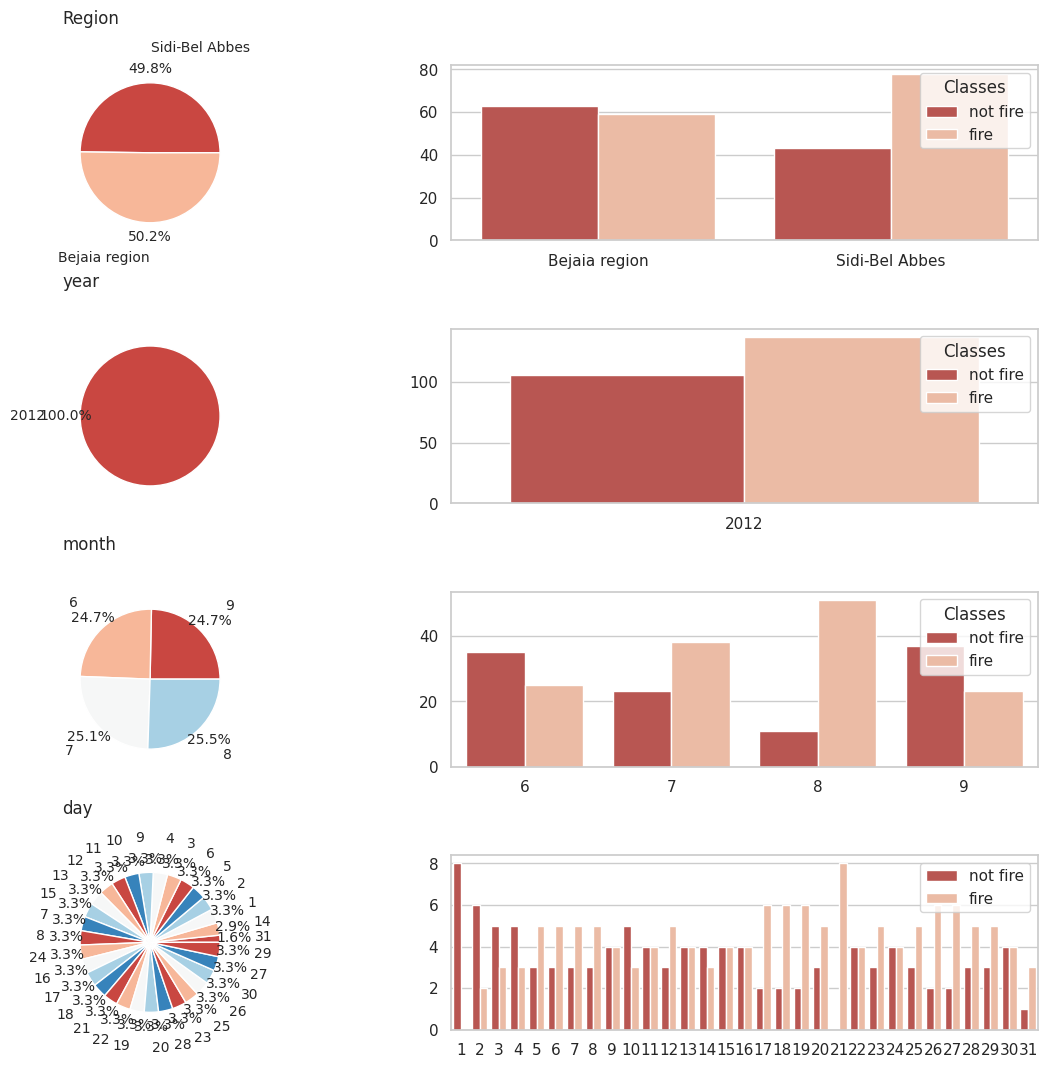

In [25]:
InteractiveShell.ast_node_interactivity = 'last_expr'
n_cat_samples(df,categorical_features , target_col='Classes', figsize=(12,13))

#### Contingency tables for categorical features

- Analyze the relationship between each categorical feature and the target variable.
- By creating contingency tables to display the frequency of each fire class for each distinct value within the categorical feature.

In [26]:
for col in categorical_features:
    print(f"\n{col}-wise Fire Occurrence:")
    info_df=pd.crosstab(df['Classes'],df[col])
    print(info_df)


Region-wise Fire Occurrence:
Region    Bejaia region  Sidi-Bel Abbes
Classes                                
fire                 59              78
not fire             63              43

year-wise Fire Occurrence:
year      2012
Classes       
fire       137
not fire   106

month-wise Fire Occurrence:
month      6   7   8   9
Classes                 
fire      25  38  51  23
not fire  35  23  11  37

day-wise Fire Occurrence:
day       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
Classes                                                                        
fire       0   2   3   3   5   5   5   5   4   3   4   5   4   3   4   4   6   
not fire   8   6   5   5   3   3   3   3   4   5   4   3   4   4   4   4   2   

day       18  19  20  21  22  23  24  25  26  27  28  29  30  31  
Classes                                                           
fire       6   6   5   8   4   5   4   5   6   6   5   5   4   3  
not fire   2   2   3   0   4   3   4   3   2

#### **OBSERVATION:**
- Region has balanced distribution across Classes
    -**Bejaia region:** 50.2% of the instances.
    - **Sidi-Bel Abbes:** 49.8% of the instances.
    - **Bejaia region** has balanced  distribution across Classes while **Sidi-Bel Abbes**, the "fire" instances are higher than "not fire" instances.

- All instances are from the year 2012 (constant variable have to be removed).
- Month has balanced distribution June (24.7%), July (25.1%), August (25.5%), and September (24.7%).
- Its observed that August had the most number of forest fires. 
- Its observed that September had the least number of forest fires. 
- Each day of the month is represented, with data relatively evenly spread across all days except day `1`

#### Encode Binary Columns

In [27]:
df['Region'] = df['Region'].map({'Bejaia region': 0, 'Sidi-Bel Abbes': 1})
df['Classes'] = df['Classes'].map({'not fire': 0, 'fire': 1})

#### Check assotiation between categorical features 
Using chi-sqaure test we can check the association between the categorical features

In [28]:
from sklearn.feature_selection import chi2

observed = pd.crosstab(df['month'], df['Region'])
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Month vs Region : chi2-statistic = {chi2_statistic:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print(f"Reject H0: the two variable are signaficantly dependent\n")
else:
    print(f"Fail to reject H0: Fail to approve that the two variable are signaficantly dependent\n")

Month vs Region : chi2-statistic = 0.0123, p-value = 0.9996
Fail to reject H0: Fail to approve that the two variable are signaficantly dependent



In [29]:
observed = pd.crosstab(df['day'], df['Region'])
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Day vs Region : chi2-statistic = {chi2_statistic:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print(f"Reject H0: the two variable are signaficantly dependent\n")
else:
    print(f"Fail to reject H0: Fail to approve that the two variable are signaficantly dependent\n")

Day vs Region : chi2-statistic = 0.1387, p-value = 1.0000
Fail to reject H0: Fail to approve that the two variable are signaficantly dependent



In [30]:
from sklearn.feature_selection import chi2

observed = pd.crosstab(df['month'], df['day'])
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Month vs day : chi2-statistic = {chi2_statistic:.4f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print(f"Reject H0: the two variable are signaficantly dependent\n")
else:
    print(f"Fail to reject H0: Fail to approve that the two variable are signaficantly dependent\n")

Month vs day : chi2-statistic = 4.3832, p-value = 1.0000
Fail to reject H0: Fail to approve that the two variable are signaficantly dependent



##### **OBSERVATION:**
- Based on the results form the chi2 tests, we failed to reject the null hypothesis (independence) and conclude that there's **NO significant association** between the variables.

#### Chi-square test between categorical features and target variable

In [31]:
from sklearn.feature_selection import chi2

print("Chi-squared Test (Categorical Features):\n")

for feature in categorical_features:
    observed = pd.crosstab(df[feature], df['Classes'])
    chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
    print(f"{feature}\t: chi2-statistic = {chi2_statistic:.4f}\t, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"\t Reject H0: Fire occurrence is dependent on {feature}\n")
    else:
        print(f"\t Fail to reject H0: Fail to approve that fire occurrence is dependent on {feature}\n")

Chi-squared Test (Categorical Features):

Region	: chi2-statistic = 5.7666	, p-value = 0.0163
	 Reject H0: Fire occurrence is dependent on Region

year	: chi2-statistic = 0.0000	, p-value = 1.0000
	 Fail to reject H0: Fail to approve that fire occurrence is dependent on year

month	: chi2-statistic = 30.9777	, p-value = 0.0000
	 Reject H0: Fire occurrence is dependent on month

day	: chi2-statistic = 32.2124	, p-value = 0.3577
	 Fail to reject H0: Fail to approve that fire occurrence is dependent on day



### Mutual inofrmation for categorical features and target variable

In [32]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(df[categorical_features].values, df['Classes'])
mutual_df = pd.DataFrame({'Features':categorical_features, 'MI score': mutual_info})
mutual_df

,Features,MI score
0,Region,0.000
1,year,0.013
2,month,0.032
3,day,0.000


##### **OBSERVATION:**
* **`month` is the most informative feature:**  With a MI score of 0.085, shows the strongest dependency on the target variable (likely 'Classes' or a similar categorical variable). 
    - The high MI score for 'month' strongly suggests that your outcome is influenced by seasonal factors. This could be due to **Weather Patterns**  as different months have distinct weather patterns (temperature, humidity, rainfall) that affect the outcome.

* **`Region` has moderate informativeness:**  A score of 0.029 indicates a moderate level of dependency. This means `Region` has some influence but is less important than `month`.
    - This could be related to **Climate** as certain regions might have specific climates that affect the outcome.

* **`year` and `day` are weakly informative:**  The very low MI scores of 0.002 and 0.000 suggest they have minimal predictive power for your target variable. 
    - We have historical data for only one year, so No pwttern from the `year` feature.
    - Daily variations might be too small or too random to have a strong impact.

---

### 2. Explore Numerical Features

#### Distribution of numerical features

Create histograms for all numerical features. This helps identify their distributions (normal, skewed, etc.) and potential outliers.

array([[<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'RH'}>, <Axes: title={'center': 'Ws'}>],
       [<Axes: title={'center': 'Rain'}>,
        <Axes: title={'center': 'FFMC'}>,
        <Axes: title={'center': 'DMC'}>],
       [<Axes: title={'center': 'DC'}>, <Axes: title={'center': 'ISI'}>,
        <Axes: title={'center': 'BUI'}>],
       [<Axes: title={'center': 'FWI'}>, <Axes: >, <Axes: >]],
      dtype=object)

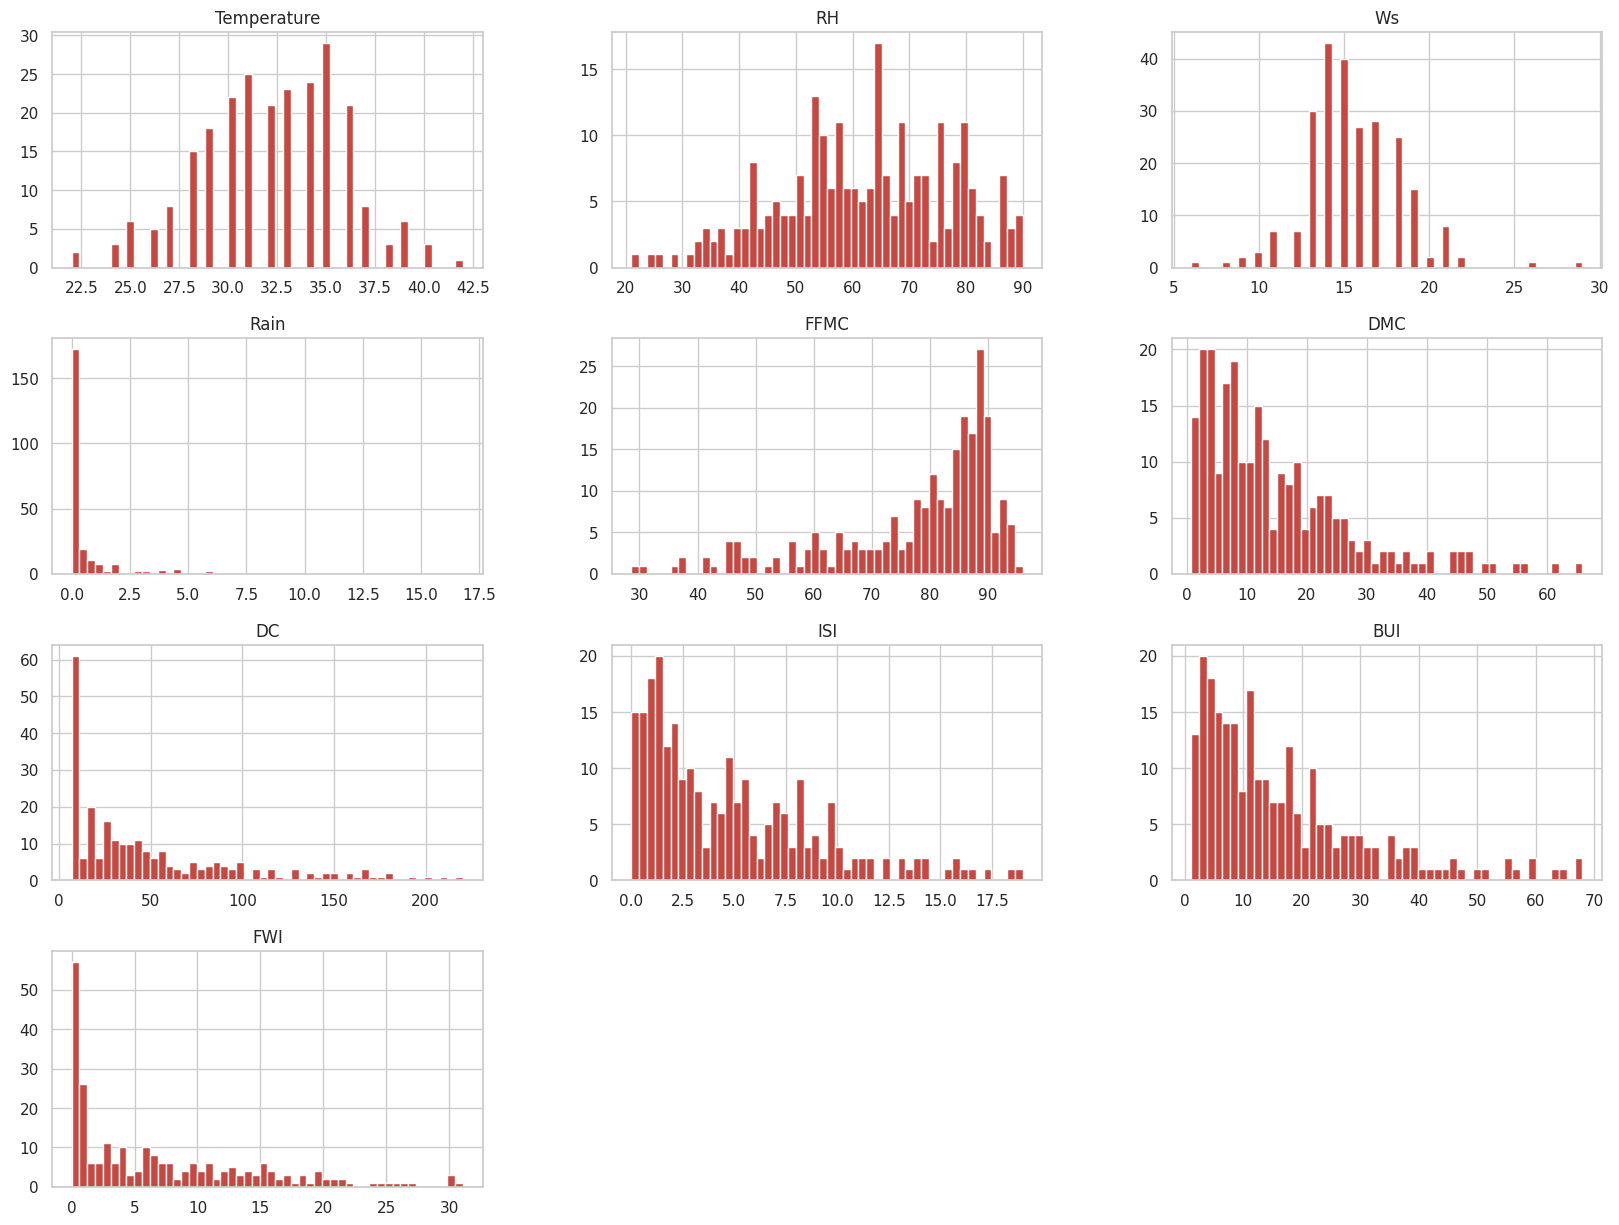

In [33]:
InteractiveShell.ast_node_interactivity = 'last_expr'
df[numerical_features].hist(bins=50,figsize=(20,15))

##### **OBSERVATION:**

- **Temperature, RH, and WS** approximately follows a Gaussian distribution.
- **Rain**:  Rainfall distribution is heavily skewed towards zero, indicating infrequent rain events.
- **FFMC (Fine Fuel Moisture Code)**: The distribution of FFMC values, ranging from 30 to 90. The values are more frequent towards the higher end (around 90).
- **DMC (Duff Moisture Code)**: The distribution of DMC values, ranging from 0 to 60, with a higher frequency of lower values (below 20).
- **DC (Drought Code)**: The distribution of DC values, ranging from 0 to 200, with most values below 50.
- **ISI (Initial Spread Index)**: The distribution of ISI values, ranging from 0 to 17.5. Most values are below 7.5.
- **BUI (Buildup Index)**: The distribution of BUI values, ranging from 0 to 70, with a higher frequency of values below 30.
- **FWI (Fire Weather Index)**: The distribution of FWI values, ranging from 0 to 30, with most values below 5.
> Normalize features like Rain, FFMC, DMC, DC, ISI, BUI, and FWI, which are skewed and have ranges that differ significantly.

#### Heatmap for numerical features
Visualize the correlation matrix for numerical features. This provides a quick overview of linear correlations.

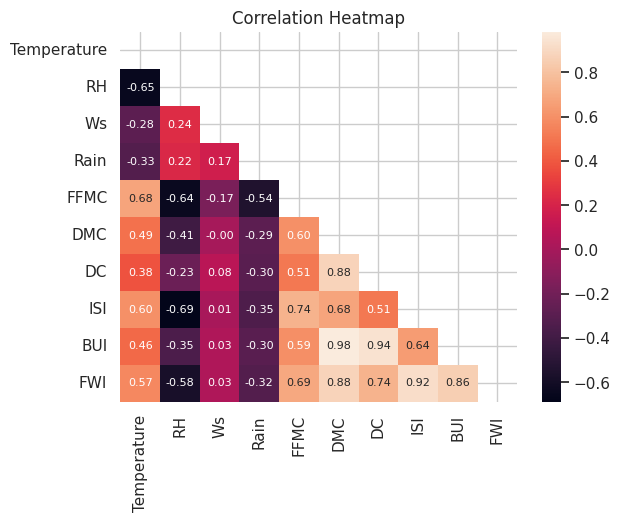

In [34]:
corr_matrix = df[numerical_features].corr()
corr_tri = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
sns.heatmap(corr_tri,fmt=".2f", annot=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap')
plt.show()

In [35]:
# from correlation return columns bigger than some threshold
for col1 in corr_tri.columns:
    for col2 in corr_tri.columns:
        if corr_tri.loc[col1, col2] > 0.8:
            print(f"correlation of {col1} and {col2} = {corr_tri.loc[col1, col2]}")

correlation of DC and DMC = 0.8759246606759622
correlation of BUI and DMC = 0.9822484890812936
correlation of BUI and DC = 0.9419884631009655
correlation of FWI and DMC = 0.8758641588191531
correlation of FWI and ISI = 0.9228949343157855
correlation of FWI and BUI = 0.8579730958964258


- We need to remove one of the features from the set of `(DMC, DC, BUI)` since they're all highly correlated with each other. 


#### Pairplot between nummerical features

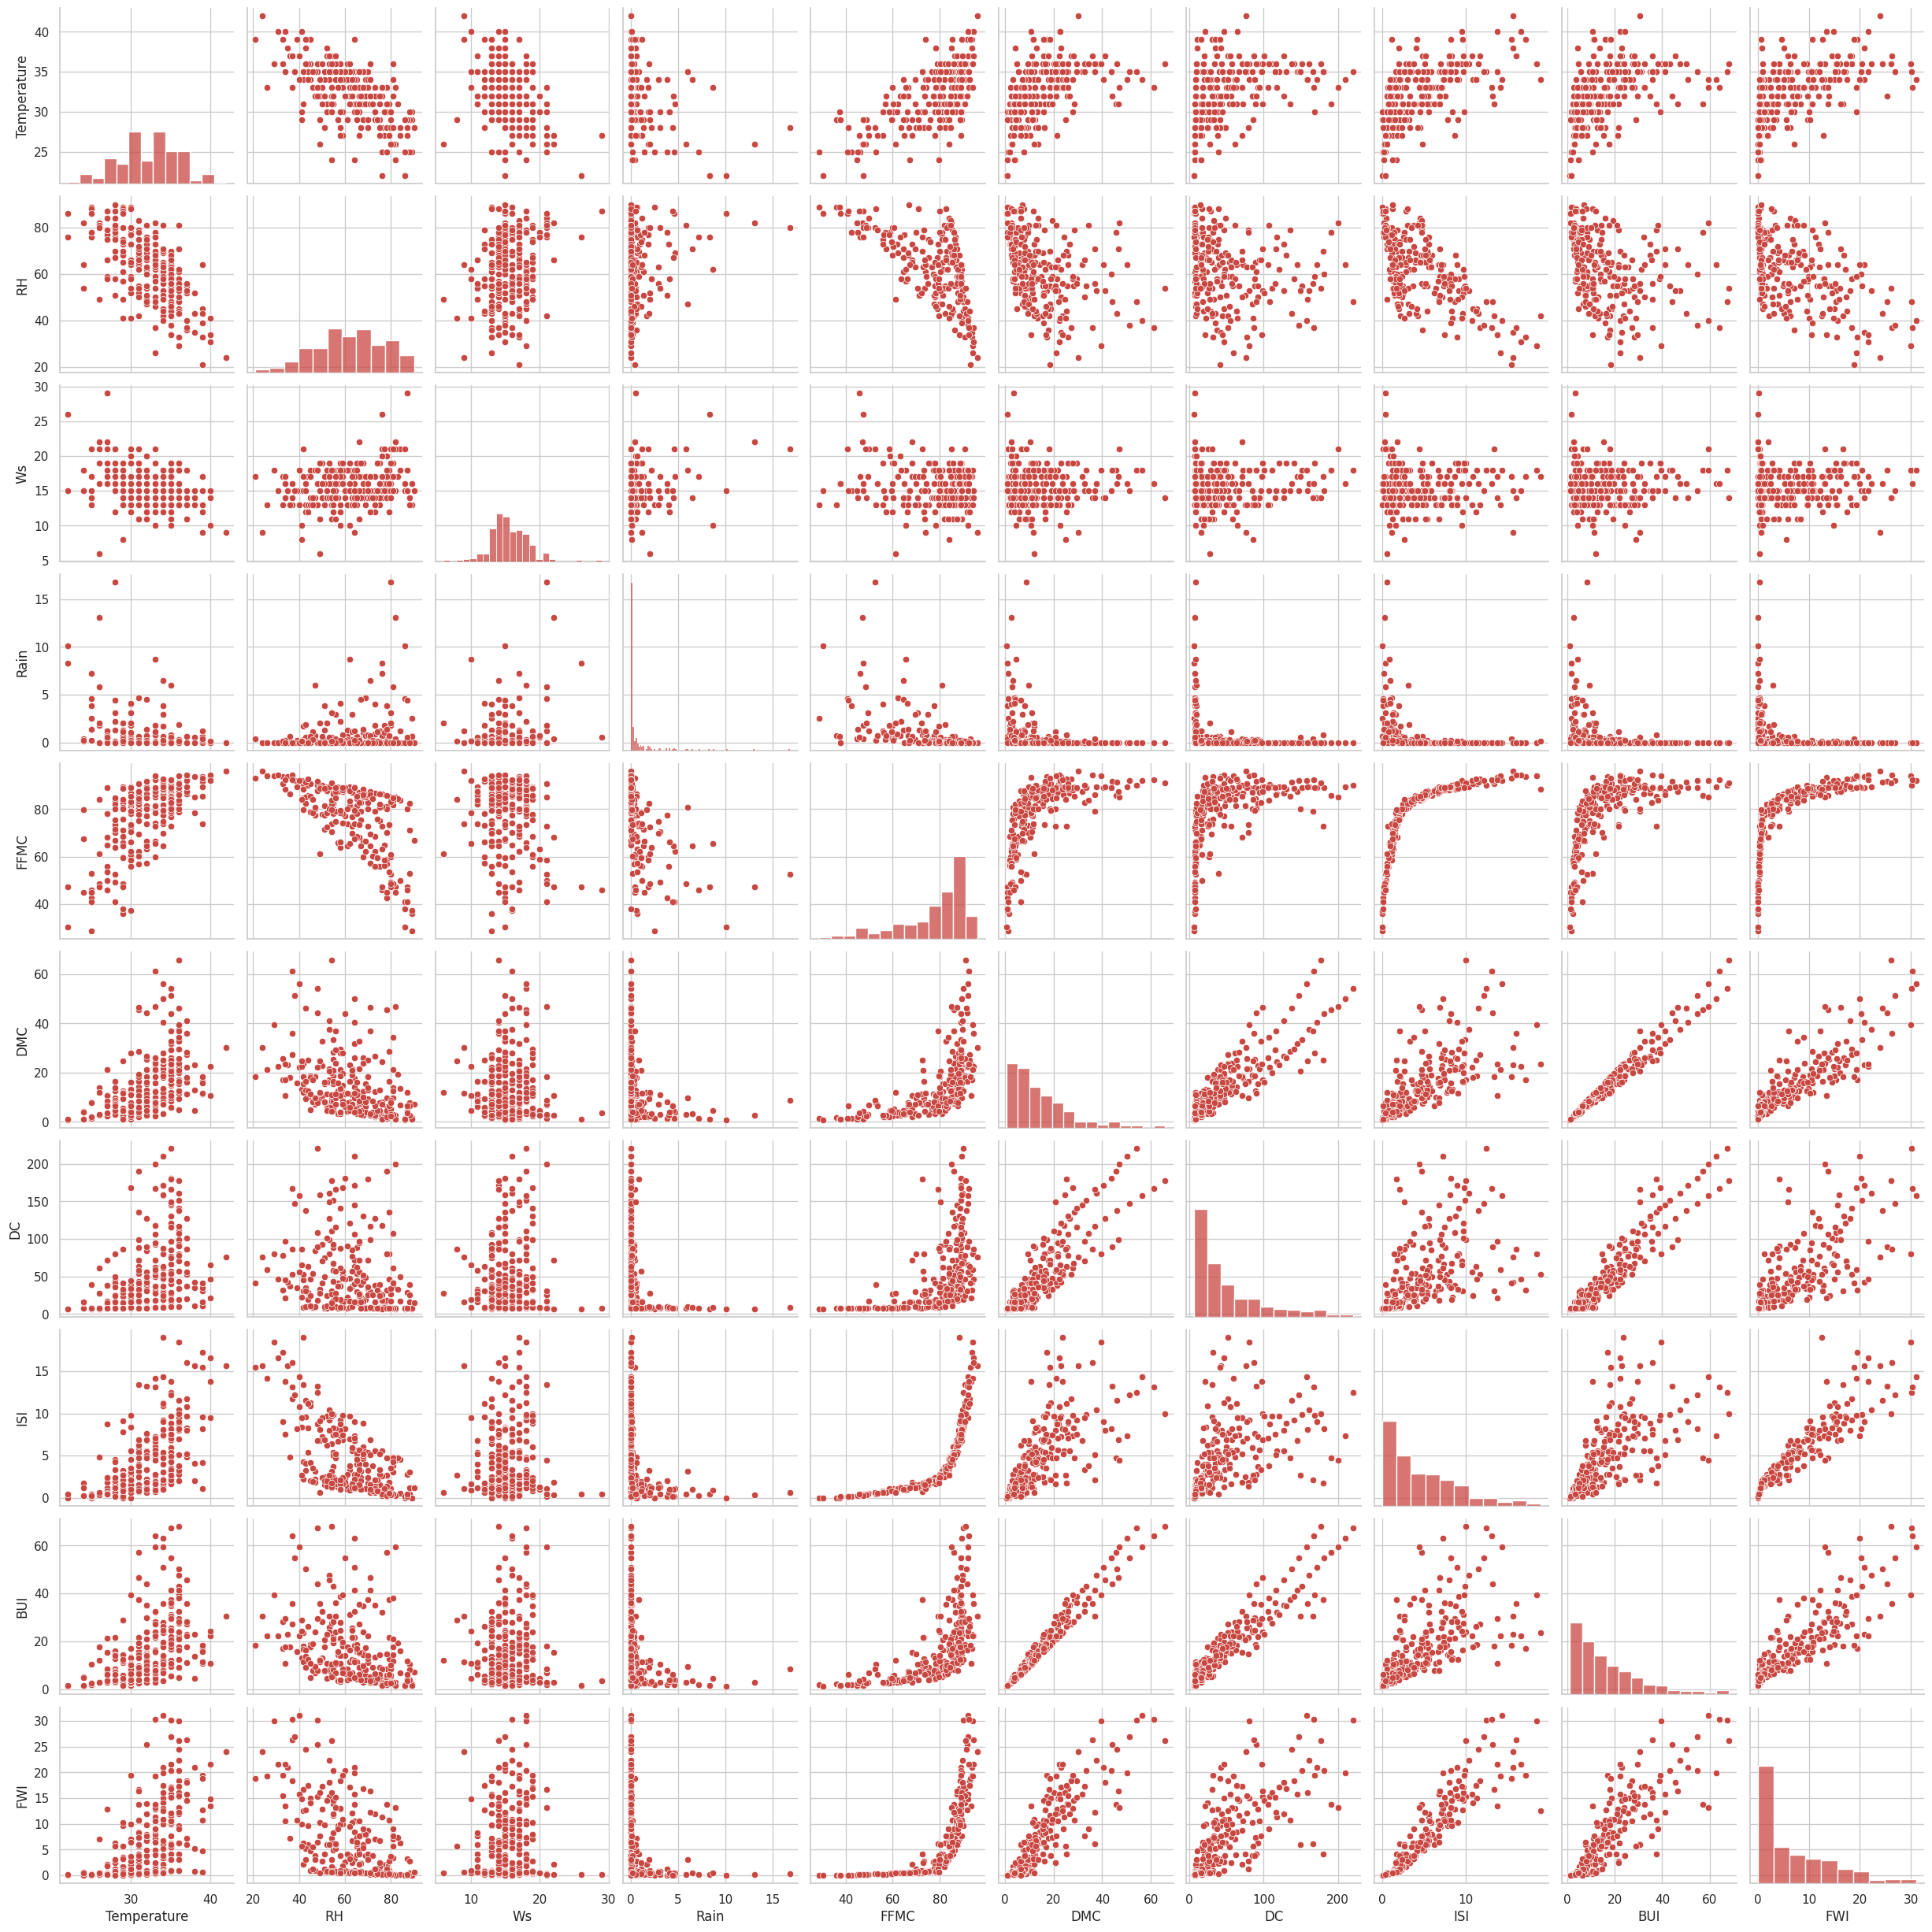

In [36]:
# plot the very correlated features 
sns.pairplot(df[numerical_features]) 

##### **OBSERVATION:** 
   
- **Temperature (Temp)**
  - Negatively correlated with Relative Humidity `RH` (linear).
  - Positively correlated with `FFMC`, `DMC`, `DC`, `ISI`, `BUI`, and `FWI` (non-linear).
  - No clear relationship with Wind Speed `Ws` and `Rain`.

- **Relative Humidity (RH)**
  - Negatively correlated with `Temperature` (linear).
  - Negatively correlated with `FFMC`, `DMC`, `DC`, `ISI`, `BUI`, and `FWI` (non-linear).
  - No clear relationship with `Rain` and `WS`.
  - No clear relationship with Wind Speed `Ws` and `Rain`.

- **Wind Speed (Ws) and Rain**
   - No correlation between WS and all other features
   - Their occurrence doesn't exhibit a consistent pattern with any of the other features.

- **Fine Fuel Moisture Code (FFMC)**:
  - Have non-linear relationship with other features.
  - Positively correlated with `Temperature`, `DMC`, `DC`, `ISI`, `BUI`, and `FWI` (linear).
  - Positively correlated with  (non-linear).
  - Negatively correlated with `RH` (non-linear).
  - No clear relationship with `Rain` and `WS`.

- **Duff Moisture Code (DMC)**
  - Have non-linear relationship with other features.
  - Positively correlated with `Temperature`, `DC`, `ISI`, `BUI`, and `FWI` (non-linear).
  - Negatively correlated with `RH` (non-linear).
  - No clear relationship with `Rain` and `WS`.

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif_data = pd.DataFrame() 
vif_data["feature"] = numerical_features

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df[numerical_features].values, i) 
                          for i in range(len(numerical_features))] 
  
print("Variance Inflation Factor (VIF):")
vif_data.sort_values(by='VIF', ascending=False)

Variance Inflation Factor (VIF):


,feature,VIF
8,BUI,402.845
5,DMC,182.267
4,FFMC,105.119
0,Temperature,97.659
9,FWI,76.318
7,ISI,52.267
6,DC,51.197
2,Ws,34.763
1,RH,30.626
3,Rain,1.652



* **BUI and DMC** A VIF of 402.845 indicates extremely high multicollinearity for the 'BUI' feature. This suggests that they are heavily influenced by other predictor variables in your model.
- Therefore, I'll remove `BUI` and `DMC` and keep the reset beacause it has the higest VIF.
- We will decide after calculate the mutual information for each of them with the target column.

### Independent t-test for numerical features
Assess the relationship between numerical features and a binary target variable. Independant t-test focuses on comparing group means and testing for significant differences. 

In [38]:
for feature in numerical_features:
    # Extract data for each group
    group0 = df[df['Classes'] == 0][feature]
    group1 = df[df['Classes'] == 1][feature]

    # Perform independent t-test
    t_statistic, p_value = stats.ttest_ind(group0, group1)
    print(f" [{feature}]\n",'-'*10)
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f">>>>> There is a statistically significant difference in the mean of `{feature}` between target groups.")
    else:
        print(f">>>>> No significant difference found in the mean of `{feature}` between target groups.")
    print('-'*100)

 [Temperature]
 ----------
T-statistic: -9.351982941248785
P-value: 6.16601521601067e-18
>>>>> There is a statistically significant difference in the mean of `Temperature` between target groups.
----------------------------------------------------------------------------------------------------
 [RH]
 ----------
T-statistic: 7.439525613647102
P-value: 1.7723198492888224e-12
>>>>> There is a statistically significant difference in the mean of `RH` between target groups.
----------------------------------------------------------------------------------------------------
 [Ws]
 ----------
T-statistic: 1.088795706785268
P-value: 0.27733156015345045
>>>>> No significant difference found in the mean of `Ws` between target groups.
----------------------------------------------------------------------------------------------------
 [Rain]
 ----------
T-statistic: 6.359892925353739
P-value: 1.0050611580508302e-09
>>>>> There is a statistically significant difference in the mean of `Rain` betwee

In [39]:
## we will use this unstead of t test if we have multiplr classes
# for feature in numerical_features:
    
#     f_statistic, p_value = stats.f_oneway( df[df['Classes'] == 0][feature], df[df['Classes'] == 1][feature])
    
#     print(f"F-statistic: {f_statistic}")
#     print(f"P-value: {p_value}")
#     if p_value < 0.05:
#         print(f">>>>> There is a statistically significant difference in the mean of `{feature}` between target groups.")
#     else:
#         print(f">>>>> No significant difference found in the mean of `{feature}` between target groups.")
#     print('-'*50)

##### **OBSERVATION:**

* **Temperature:** A very strong relationship (p-value close to 0). It's very likely that temperature plays a crucial role in predicting your target variable.
* **RH (Relative Humidity):**  Also a strong relationship (p-value very low). Humidity likely has a significant impact on your target variable.
* **Rain:** Significant but slightly weaker than Temperature and RH. This suggests that rain could be a contributing factor.
* **FFMC (Fine Fuel Moisture Code):** Extremely strong relationship. Indicates this feature is very important.
* **DMC (Duff Moisture Code):** Strong relationship. Important for prediction. 
* **DC (Drought Code):** Strong relationship. Important for prediction.
* **ISI (Initial Spread Index):** Extremely strong relationship. Likely very impactful.
* **BUI (Buildup Index):** Strong relationship. Important for prediction.
* **FWI (Fire Weather Index):** Extremely strong relationship. Very important.
* **Ws (Wind Speed):** The p-value is higher than 0.05, suggesting there's no significant difference in the mean of wind speed between the target groups. This indicates that wind speed might not be a strong predictor for your target variable.

#### Standarization of nummerical features

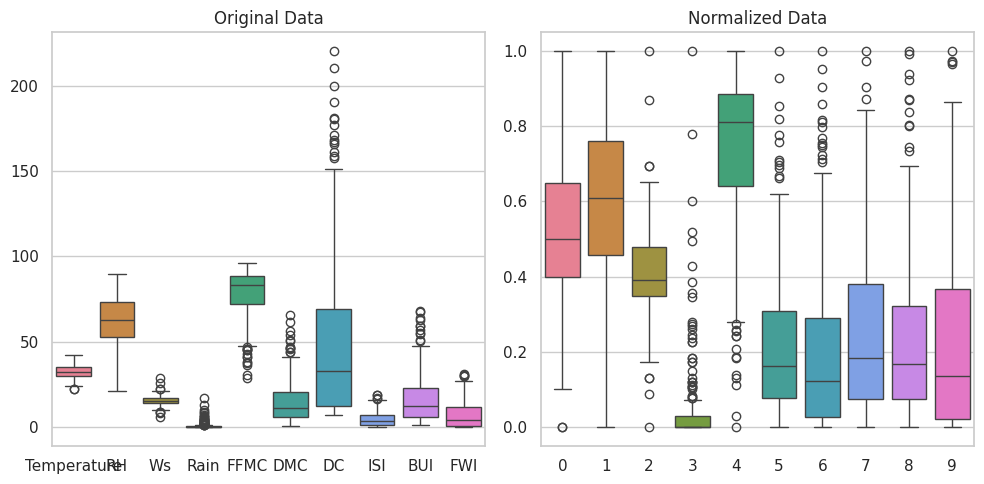

In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot for original data
sns.boxplot(data=df[numerical_features], ax=axes[0])
axes[0].set_title('Original Data')

# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[numerical_features])
df[numerical_features] = normalized_data

# Boxplot for normalized data
sns.boxplot(data=normalized_data, ax=axes[1])
axes[1].set_title('Normalized Data')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

### 3. Permutation Feature Importance

Assesses the importance of a feature by randomly shuffling its values and observing how the model's performance (e.g., accuracy, AUC) changes. A larger decrease in performance when shuffling a feature indicates higher importance.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [42]:
X = df.drop('Classes', axis=1) 
y = df['Classes']

In [43]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

/tmp/ipykernel_1698/990541570.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


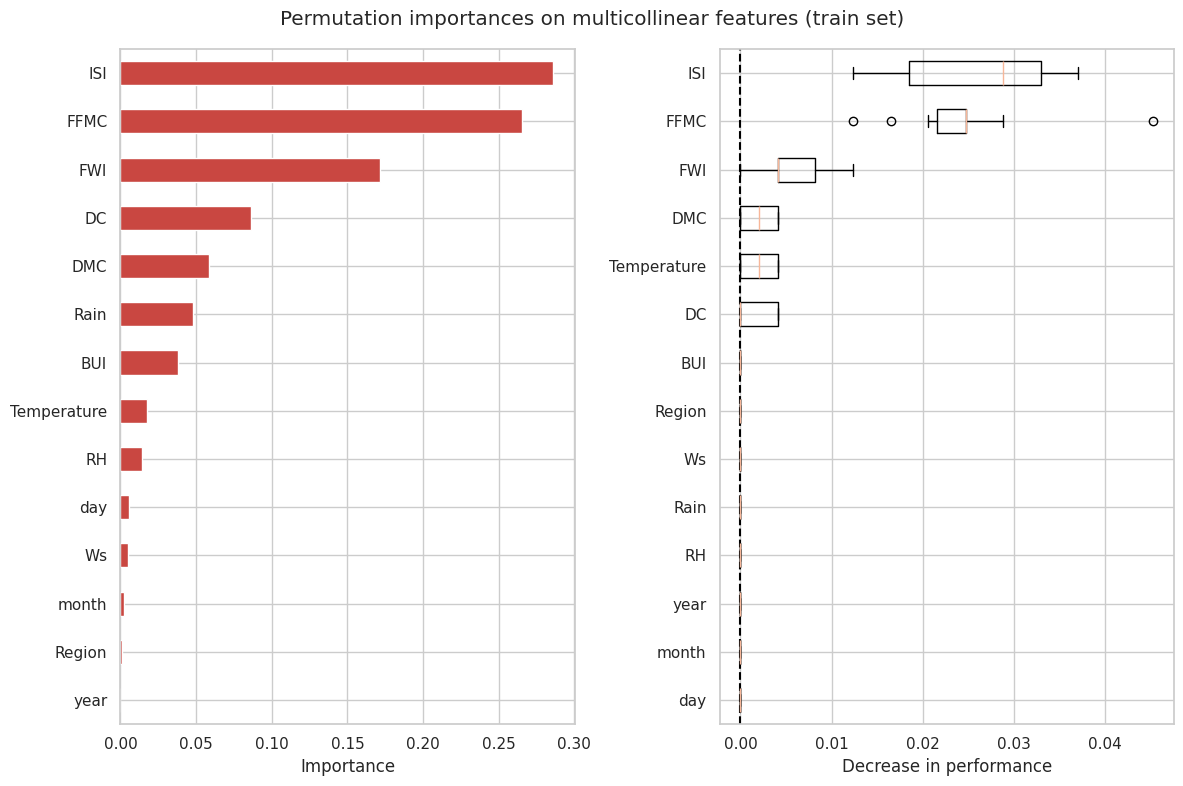

In [44]:
clf = RandomForestClassifier().fit(X,y)

mdi_importances = pd.Series(clf.feature_importances_, index=X.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Importance")
plot_permutation_importance(clf, X, y, ax2)
ax2.set_xlabel("Decrease in performance")
fig.suptitle(
    "Permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()


---
<h1 style="text-align:center;"><font color = "#2471A3">Feature Engineering</font></h1>

---

### Feature Generation

In [45]:
# Create new features based on existing ones
# X['Temp_RH'] = X['Temperature'] * X['RH']
# X['Wind_Rain'] = X['Ws'] * X['Rain']

### Feature Selection

##### Remove zero variance feature

In [46]:
X.drop(columns=['year'], inplace=True)

##### Use Recursive Feature Elimination 

In [47]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfecv = RFECV(
    estimator=LogisticRegression(),
    step=1,
    cv=5,
    scoring="roc_auc",
    # min_features_to_select=4,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)

Optimal number of features: 3
Selected features: Index(['FFMC', 'ISI', 'FWI'], dtype='object')


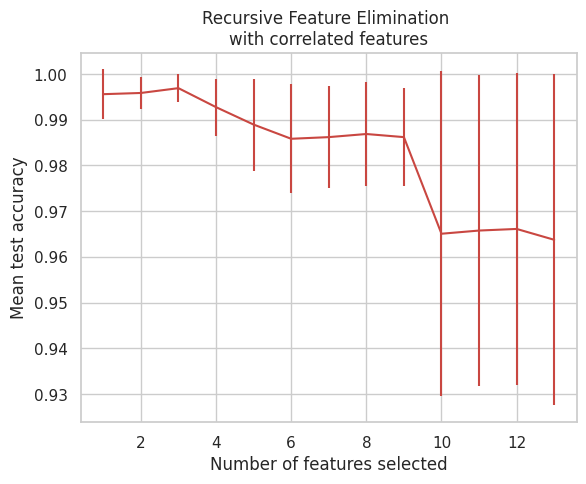

In [48]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


---
<h1 style="text-align:center;"><font color = "#2471A3">Developing Classification Model</font></h1>

---

In [51]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

In [52]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant': LinearDiscriminantAnalysis(), 
    'Quadratic Discriminant':QuadraticDiscriminantAnalysis(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}


In [53]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

results = []
for name, model in models.items():
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append((name, cv_results.mean()))

In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from time import time

results = []
for name, model in models.items():
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    start_train = time()
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    end_train = time()

    results.append((name, cv_results.mean(), end_train - start_train))

In [55]:
df_results = pd.DataFrame(results, columns=['Model', 'Mean AUC', 'Training Time (s)'])
print(df_results.to_string(index=False))

                 Model  Mean AUC  Training Time (s)
   Logistic Regression     0.998              0.071
   Linear Discriminant     0.998              0.043
Quadratic Discriminant     0.998              0.043
         Decision Tree     0.975              0.042
         Random Forest     0.998              1.286
   K-Nearest Neighbors     0.992              0.062


**Based on performance (mean AUC), complexity, and hyperparameter tuning:**
- `Linear Discriminant Analysis (LDA)` and `Quadratic Discriminant Analysis (QDA)` stand out as strong candidates. They achieve top performance, are very simple in terms of complexity, and require no hyperparameter tuning. This makes them efficient and easy to deploy.
- `Logistic Regression` is also a good choice, especially if we want more control over regularization and the ability to handle non-linear relationships (though it might be slightly more complex than LDA/QDA).

In [56]:
# Define hyperparameter grid for tuning
# param_grid = {
#     'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
#     'Decision Tree': {'max_depth': [3, 5, 7, 9, None], 'criterion': ['gini', 'entropy']},
#     'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9, None]},
#     'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
# }
# grid = GridSearchCV(best_model, param_grid[best_model_name], cv=5, scoring='accuracy')
# grid.fit(X_train, y_train)

In [57]:
# Print best parameters and accuracy
# print(f'Best parameters for {best_model_name}: {grid.best_params_}')
# print(f'Best accuracy for {best_model_name}: {grid.best_score_:.4f}')

In [58]:
# Train the best model with tuned hyperparameters
# best_model = grid.best_estimator_
# best_model.fit(X_train, y_train)

In [59]:
best_model = models['Quadratic Discriminant']
best_model.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [60]:
# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1])

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9796
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        22
           1       0.96      1.00      0.98        27

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49



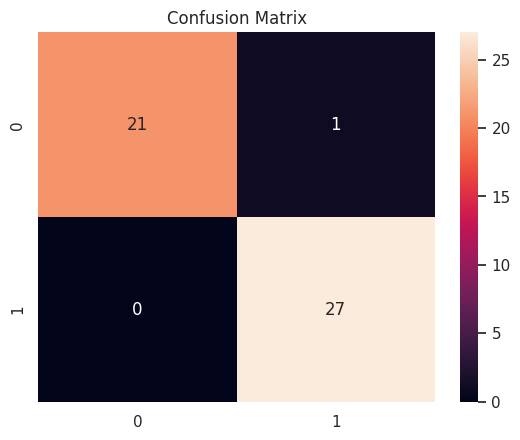

In [62]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()